# Geomechanical Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Density Log

### Estimiate Sv

In [2]:
from scipy.integrate import cumtrapz

In [3]:
density_log = pd.read_csv('Data/Barnett_density_data.csv')
density_log.head(1)

,Depth(ft),Density (g/cc)
0,100.5,1.8778


In [4]:
density_log.rename(columns={'Depth(ft)': 'Depth (ft)'}, inplace=True)

In [5]:
def Extrapolate(density_log):
    depths = np.arange(0, 100.5, 0.5)
    densities = np.full_like(depths, 1.8778)

    df = pd.DataFrame()
    df['Depth (ft)'] = depths
    df['Density (g/cc)'] = densities
    density_log = pd.concat([df, density_log], ignore_index=True)
    
    return density_log

density_log = Extrapolate(density_log)

density_log['Sv (psi)'] = 0.443*cumtrapz(density_log['Density (g/cc)'], density_log['Depth (ft)'], initial=0)

## Sonic Log

In [6]:
assumed_empirical_equtions = pd.read_excel('Data/Barnett_assumed_formations_emperical_equations.xls')
assumed_empirical_equtions

,Formation name,Depth range (ft),Formation Type,Estimate from sonic logs,Estimate from density logs
0,Marble Falls,5000.0 - 5167.0,Limestone,"Table 4.3, Equation 22","Table 4.3, Equation 26"
1,Duffer,5167.5 - 5514.0,Limestone,"Table 4.3, Equation 23","Table 4.3, Equation 26"
2,Barnett,5514.5 - 6195.0,Shale,"Table 4.2, Equation 16","Table 4.2, Equation 17"


In [7]:
sonic_log = pd.read_excel('Data/Reservoir_Geomechanics_MOOC_2020_Homework_3_answers.xlsx')
sonic_log.head(2)

,Depth (ft),compressional wave velocity (m/s),shear wave velocity (m/s),Youngs modulus (MPa),formation name,unconfined compressive strength from sonic logs (psi),unconfined compressive strength from density logs (psi)
0,5000.0,3944.073861,2654.090504,36819.975886,Marble Falls,12573.542711,8596.219011
1,5000.5,3900.451470,2670.163810,35994.606155,Marble Falls,12428.999306,8067.091795


In [8]:
Data = pd.merge(sonic_log, density_log, on='Depth (ft)', how='inner')

## Fracture Data

In [9]:
fractures = pd.read_excel('Data/Barnett_fractures.xls')
fractures = fractures.loc[:, fractures.columns[:5]]
fractures.head(2)

,depth (foot),strike (degree),dip (degree),dip_direction (degree),aperture (millimeter)
0,5200.824,228.25,76.41,318.25,4.31
1,5200.965,207.80,86.11,297.80,5.87


## Constrain SH

Depth = 5725 ft

S3_grad = 0.65 psi/ft

Lower bound of Pm = 0.48 psi/ft

Coefficient of Sliding Friction = 0.75

Mud Pressure = 0.53 psi/ft

Pp = 0.48 psi/ft 

No Tensile Fracture 

No Breakouts

Tensile Strength = 0

Breakouts Width = 0

In [10]:
Sv = Data['Sv (psi)'][Data['Depth (ft)'] == 5725].values.round(3)
C0 = (Data['unconfined compressive strength from sonic logs (psi)'][Data['Depth (ft)'] == 5725].values).round(2)
S3 = 0.65 * 5725
Pm = 0.53*5725
Pp = 0.48*5725
T0 = 0

In [11]:
print(f'Overburden Stress is {Sv[0]}')
print(f'S3 is {S3}')
print(f'Pore pressure is {Pp}')
print(f'Mud pressure is {Pm}')
print(f'UCS is {C0[0]}')

Overburden Stress is 6442.345
S3 is 3721.25
Pore pressure is 2748.0
Mud pressure is 3034.25
UCS is 12659.88


Sv > S3

In [12]:
Sh = S3

In [13]:
import Utils as ut

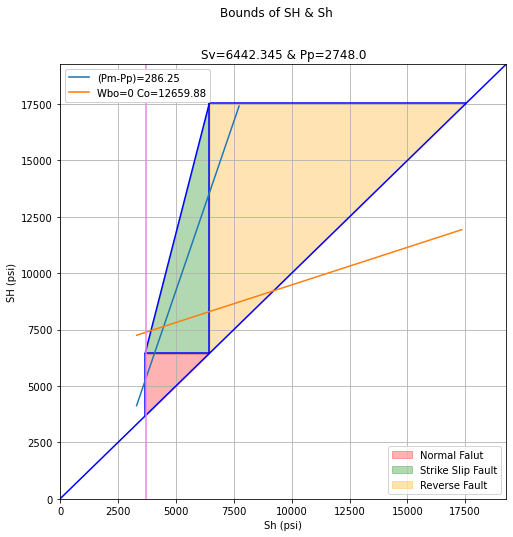

In [14]:
ax = ut.StressPolygonAdjusted(Sv[0], Pp, Pm, C0[0], wbo=0, T0=0, mu=0.75)
ax.vlines(S3, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='violet')
ax.set_xlabel('Sh (psi)')
ax.set_ylabel('SH (psi)')
plt.show()

In [15]:
f_mu = ut.CriticalStateFunction(0.75)
SH_max = 3*Sh - 2*Pp - (Pm-Pp) + T0 
print(f'Lower Bound of SH is {Sh:0.3f}')
print(f'Upper Bound of SH is {SH_max:0.3f}')

Lower Bound of SH is 3721.250
Upper Bound of SH is 5381.500


In [16]:
def phi(S1, S2, S3):
    return (S2-S3)/(S1-S3)

def Aphi(phi, n):
    return (n+0.5)+(-1)**n * (phi-0.5)

In [17]:
phi_low = phi(Sv, Sh, Sh)
phi_upp = phi(Sv, SH_max, Sh)
print(f'phi min is {phi_low}')
print(f'phi max is {phi_upp}')

phi min is [0.]
phi max is [0.6101404]


In [18]:
Aphi_max = Aphi(phi_upp, n=0)
Aphi_min = Aphi(phi_low, n=0)
print(f'Aphi max is {Aphi_max}')

Aphi max is [0.6101404]
